<a href="https://colab.research.google.com/github/variableVG/CV_project/blob/master/05_data_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data and images

In [2]:
! pip install gdown
! mkdir -p /content/pic/
! gdown -O /content/pictures_small.tar "1RVa4YzGpGidql_NOb69bYgpLZcdZD98b"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1RVa4YzGpGidql_NOb69bYgpLZcdZD98b
To: /content/pictures_small.tar
100% 5.39M/5.39M [00:00<00:00, 211MB/s]


In [3]:
import tarfile
try: 
  tar = tarfile.open('/content/pictures_small.tar')
  tar.extractall(path='/content/pic')
  tar.close()
except:
  print("Pictures could not be extracted")

In [4]:
! mv /content/pic/content/small_pics/* /content/pic/
! rmdir /content/pic/content

rmdir: failed to remove '/content/pic/content': Directory not empty


In [5]:
path_to_pictures = '/content/pic/'
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces_small.csv'

In [6]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [7]:
df = pd.read_csv(path_to_dataset)

In [8]:
df.head()

,filename,age,gender,ethnicity
0,36_1_1_20170116153744623.jpg,36,1,1
1,37_0_1_20170116002833730.jpg,37,0,1
2,37_0_1_20170117143125092.jpg,37,0,1
3,37_1_1_20170116001322849.jpg,37,1,1
4,37_1_1_20170116232758932.jpg,37,1,1


In [9]:
df.shape

(1251, 4)

## Get pictures as numpy arrays

In [10]:
# WARNING: This might take long
from tqdm import tqdm
from pathlib import Path
images = []

for image in tqdm(df['filename']):
  path = path_to_pictures + image
  try: 
    img = Image.open(path).convert('RGB') # I use that to make sure all the pictures are RGB
    images.append(img)
    #img = np.array(img)
  except FileNotFoundError as e:
    print(e)
  

100%|██████████| 1251/1251 [00:00<00:00, 1443.12it/s]


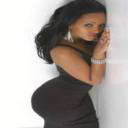

In [11]:
images[0]

In [12]:
# Check sizes
for idx, img in enumerate(images[0:5]):
  img_array = np.array(img)
  print(f"Image {idx} has shape {img_array.shape}")

Image 0 has shape (128, 128, 3)
Image 1 has shape (128, 128, 3)
Image 2 has shape (128, 128, 3)
Image 3 has shape (128, 128, 3)
Image 4 has shape (128, 128, 3)


In [13]:
img_size = (64, 64)

# Normalize Pictures with PyTorch

The normalization can constitute an effective way to speed up the computation in the model based on neural network architecture and learn faster by reducing the skewness. 

There are 2 steps to normalize the images: 


1.   Substract the channel mean from each input channel
2.   Dived it by the channel standard deviation

When we transformed an image into a PyTorch tensor, the pixel values are scaled between 0 and 1. In PyTorch, this transformation is done usint torchvision.transforms.ToTensor(). This converts the PIL image with a pixel range of 0 to 255 to a PyTorch FloatTensor of shape (C, H, W) with a range from 0 to 1. 

**Normalizing the images means transforming the images into such values that the mean and stadard deviation of the image become 0 and 1 respectively.**

To actually normalize the image, then we use torchvision.transforms.Normalize(). 

Normalize() takes 2 parameters: 
* mean: Sequeance of means for each channel. 
* std. Sequence of standard deviations for each channel. 
And it returns a normalized tensor image. 

To normalize the image we first calculate the mean and standard deviation of 10 random pictures. 

In [14]:
# Transform images to tensor images: 
tensor_images = []
for idx, img in enumerate(images):
  tensor_img = (T.ToTensor())(img) # Transform image to pixel values btw 0 and 1
  tensor_images.append(tensor_img)

Text(0.5, 1.0, 'distribution of pixels for first picture')

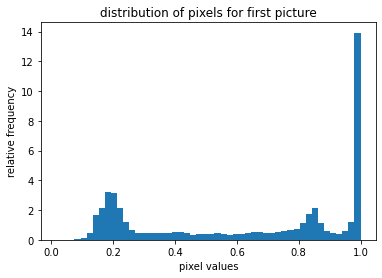

In [15]:
# Plot pixel values of first image: 
array_img = np.array(tensor_images[0])

plt.hist(array_img.ravel(), bins=50, density=True)
plt.xlabel('pixel values')
plt.ylabel('relative frequency')
plt.title('distribution of pixels for first picture')

In [16]:
# Calculate mean and standard deviation for 10 random pictures: 
import random
mean_pixels = torch.zeros([3, 10])
std_pixels = torch.zeros([3, 10])

for idx, img in enumerate(random.sample(tensor_images, k=10)):
  mean = img.mean([1,2])
  std = img.std([1,2])
  mean_pixels[:, idx] = mean 
  std_pixels[:, idx] = std

mean = mean_pixels.mean(1)
std = std_pixels.mean(1)

print(f"Mean of 10 random images: {mean}")
print(f"Std of 10 random images: {std}")

Mean of 10 random images: tensor([0.5344, 0.4811, 0.4267])
Std of 10 random images: tensor([0.2344, 0.2154, 0.2300])


In [17]:
normalized_images_tensor = []
# normalized_images = []

# Instanciate Normalize() function with calculated mean and std
normalizer = T.Normalize(mean=list(mean), std=list(std))

for idx, img in enumerate(tensor_images):
  try: 
    normalized_img = normalizer(img)
    normalized_images_tensor.append(normalized_img)
    #normalized_img = T.ToPILImage()(normalized_img)
    #normalized_images.append(normalized_img)
  except RuntimeError as e:
    # delete from the df: it is not working but i do not know why
    # df = df.drop(index=idx)
    print(f"Normalization failed in index {idx}: {e}")
    print("Picture will be converted or deleted.")


In [18]:
print(f"Normalized lists lenght is {len(normalized_images_tensor)}")
print(f"df shape is {df.shape}")

Normalized lists lenght is 1251
df shape is (1251, 4)


In [19]:
normalized_images_tensor[0]

tensor([[[1.9868, 1.9868, 1.9868,  ..., 1.2840, 1.3175, 1.3342],
         [1.9868, 1.9868, 1.9868,  ..., 1.2840, 1.3008, 1.3342],
         [1.9868, 1.9868, 1.9868,  ..., 1.2673, 1.3008, 1.3342],
         ...,
         [1.9868, 1.9868, 1.9868,  ..., 1.3510, 1.3844, 1.4179],
         [1.9868, 1.9868, 1.9868,  ..., 1.3510, 1.3844, 1.4179],
         [1.9868, 1.9868, 1.9868,  ..., 1.3510, 1.3844, 1.4179]],

        [[2.4085, 2.4085, 2.4085,  ..., 1.6258, 1.6623, 1.6805],
         [2.4085, 2.4085, 2.4085,  ..., 1.6258, 1.6441, 1.6805],
         [2.4085, 2.4085, 2.4085,  ..., 1.6076, 1.6441, 1.6805],
         ...,
         [2.4085, 2.4085, 2.4085,  ..., 1.7169, 1.7533, 1.7897],
         [2.4085, 2.4085, 2.4085,  ..., 1.7169, 1.7533, 1.7897],
         [2.4085, 2.4085, 2.4085,  ..., 1.7169, 1.7533, 1.7897]],

        [[2.4579, 2.4579, 2.4579,  ..., 1.8954, 1.9295, 1.9465],
         [2.4579, 2.4579, 2.4579,  ..., 1.8954, 1.9124, 1.9465],
         [2.4579, 2.4579, 2.4579,  ..., 1.8783, 1.9124, 1.

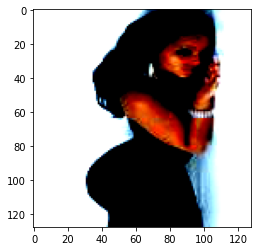

In [20]:
plt.imshow(normalized_images_tensor[0].permute(1, 2, 0)  )

# Save tensors

In [22]:
df.shape
len(normalized_images_tensor)

1251

In [27]:
path_to_save_pictures = '/content/drive/MyDrive/Colab Notebooks/CVNLP/normalized_tensor_images/'

In [31]:
import os
for idx, img in enumerate(normalized_images_tensor): 
  basename, extension = os.path.splitext(df['filename'][idx]) # get filename without extension
  path = path_to_save_pictures + basename + '.pth' # extension pth is for pythorch files
  torch.save(img, path)

In [ ]:
# Source: https://discuss.pytorch.org/t/storing-images-as-tensor/20096/3